### Importing libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error


import utils


#### Loading and splitting training data

In [3]:
training_data = pd.read_csv("./data/train.csv")
variables = list(training_data.columns)
y = training_data["rh98"]
X = training_data.drop(columns=["rh98"])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_calib, y_test, y_calib = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [5]:
train_coords = X_train[["lat", "lon"]]
X_train.drop(columns=["lat", "lon"], inplace=True)

test_coords = X_test[["lat", "lon"]]
X_test.drop(columns=["lat", "lon"], inplace=True)

calib_coords = X_calib[["lat", "lon"]]
X_calib.drop(columns=["lat", "lon"], inplace=True)

#### Load models 

In [6]:
confidence = 0.95
miscoverage = 1-confidence
alpha_low = round(miscoverage/2, 3)
alpha_upp = round(1-miscoverage/2, 3)

with open(f'./lightGradientBoosting.pickle', 'rb') as file:
   lgb = pickle.load(file)
with open(f'./{alpha_low}_quantileRegressor.pickle', 'rb') as file:
   lgb_low = pickle.load(file)
with open(f'./{alpha_upp}_quantileRegressor.pickle', 'rb') as file:
   lgb_upp = pickle.load(file)

## Prediction and uncertainty quantification
After loading the models they are applied to the test dataset. Their performance is assess using the R² score and the RSME. The point estimator reaches a RSME of 538 while exhibiting a coefficient of determination of 0.68. 

|/|R²      |RSME|
|------------------------------------|--------|----|
|LGBM point estimator                |0.68    |535 |
|LGBM lower quantile estimator       |0.60    |598 |
|LGBM upper quantile estimator       |0.59    |600 |

In [7]:
y_pred = lgb.predict(X_test)
with open('./lightGradientBoosting.pickle', 'rb') as file:
   lgb = pickle.load(file)
y_pred = lgb.predict(X_test)
lgb_r2 = r2_score(y_test, y_pred)
lgb_rsme = root_mean_squared_error(y_test, y_pred)
print(f'LGBM performance: R²: {round(lgb_r2, 2)} RSME: {round(lgb_rsme)}')

y_pred_low = lgb_low.predict(X_test)
with open('./lightGradientBoosting.pickle', 'rb') as file:
   lgb = pickle.load(file)
y_pred = lgb_low.predict(X_test)
lgb_r2 = r2_score(y_test, y_pred)
lgb_rsme = root_mean_squared_error(y_test, y_pred)
print(f'LGBM (lower quantile) performance: R²: {round(lgb_r2, 2)} RSME: {round(lgb_rsme)}')

y_pred_upp = lgb_upp.predict(X_test)
with open('./lightGradientBoosting.pickle', 'rb') as file:
   lgb = pickle.load(file)
y_pred = lgb_upp.predict(X_test)
lgb_r2 = r2_score(y_test, y_pred)
lgb_rsme = root_mean_squared_error(y_test, y_pred)
print(f'LGBM (upper quantile) performance: R²: {round(lgb_r2, 2)} RSME: {round(lgb_rsme)}')

LGBM performance: R²: 0.68 RSME: 535
LGBM (lower quantile) performance: R²: 0.6 RSME: 598
LGBM (upper quantile) performance: R²: 0.59 RSME: 600


### Calibration of quantile regressors
The efficiency and reliability of the uncertainty estimates can assessed using the size and the coverage metrics. The size captures the mean length of the prediction intervals while the coverage refers to the proportion of true values that fall within the estimated intervals. The former should be as small as possible (depending on the use case) while the latter should at east match the desired confidence / miscoverage level. Since the quantile regressors did not achieve the desired confidence or miscoverage they have to be calibrated using for example conformalised approaches. Additionally these approaches are distribution and model agnostic. They are also able to pick up on heteroscedasticities in the errors [2, 3, 4].

As we can see our "raw" quantile regression (QR) only reached a coverage of about 50% despite being trained for 95%. The fix this, they were corrected using the conformalised quantile regression (CQR) approach. If done right a coverage very close to the desired 95% can be guaranteed when using exchangeable data. To make these guarantees can even be improved using the signed conformal quantile regression (SCQR) approach can be used. 

The CQR and SCQR could achieve much higher coverages when compared to the "raw" QR. In fact they are almost perfectly calibrated. Since CQR and SCQR approaches tend to be quite conservative estimators of uncertainty the actual predictive intervals are no longer efficient enough to be interpreted in a meaningful way. This might be counteracted by more sophisticated quantile estimators or simple more training and calibration data. 

|/|Coverage|Size   |
|------------------------------------|--------|-------|
|Quantile regression                 |0.5001  |284    |
|Conformal quantile regression       |0.9965  |2229   |
|Signed conformal quantile regression|0.9972  |2236   |

In [12]:
qr_size = utils.size(y_pred_low, y_pred_upp)
qr_coverage = utils.coverage(y_pred, y_pred_low, y_pred_upp)
print(f'Quantile regression performance: Coverage: {round(qr_coverage, 4)} Size: {round(qr_size)}')

correction_factor = utils.correction_factor(lgb_low, lgb_upp, X_calib, y_calib, miscoverage)
y_pred_low_cqr = y_pred_low - correction_factor
y_pred_low_cqr = [0 if x < 0 else x for x in y_pred_low_cqr]
y_pred_upp_cqr = y_pred_upp + correction_factor

cqr_size = utils.size(y_pred_low_cqr, y_pred_upp_cqr)
cqr_coverage = utils.coverage(y_pred, y_pred_low_cqr, y_pred_upp_cqr)
print(f'Conformal quantile regression performance: Coverage: {round(cqr_coverage, 4)} Size: {round(cqr_size)}')

lower_correction_factor, upper_correction_factor = utils.signed_correction_factor(lgb_low, lgb_upp, X_calib, y_calib, miscoverage)
y_pred_low_scqr = y_pred_low - lower_correction_factor
y_pred_low_scqr = [0 if x < 0 else x for x in y_pred_low_scqr]
y_pred_upp_scqr = y_pred_upp + upper_correction_factor

scqr_size = utils.size(y_pred_low_scqr, y_pred_upp_scqr)
scqr_coverage = utils.coverage(y_pred, y_pred_low_scqr, y_pred_upp_scqr)
print(f'Signed conformal quantile regression performance: Coverage: {round(scqr_coverage, 4)} Size: {round(scqr_size)}')

Quantile regression performance: Coverage: 0.5001 Size: 284
Conformal quantile regression performance: Coverage: 0.9965 Size: 2229
Signed conformal quantile regression performance: Coverage: 0.9972 Size: 2236


In [9]:
X_test["rh98"] = y_test
X_test["rh98_error"] = abs(y_test-y_pred)
X_test["rh98_pred"] = y_pred
X_test["rh98_pred_low"] = y_pred_low_scqr
X_test["rh98_pred_upp"] = y_pred_upp_scqr
X_test["rh98_pred_size"] = abs(y_pred_upp_scqr-y_pred_low_scqr)
X_test = X_test.join(test_coords)

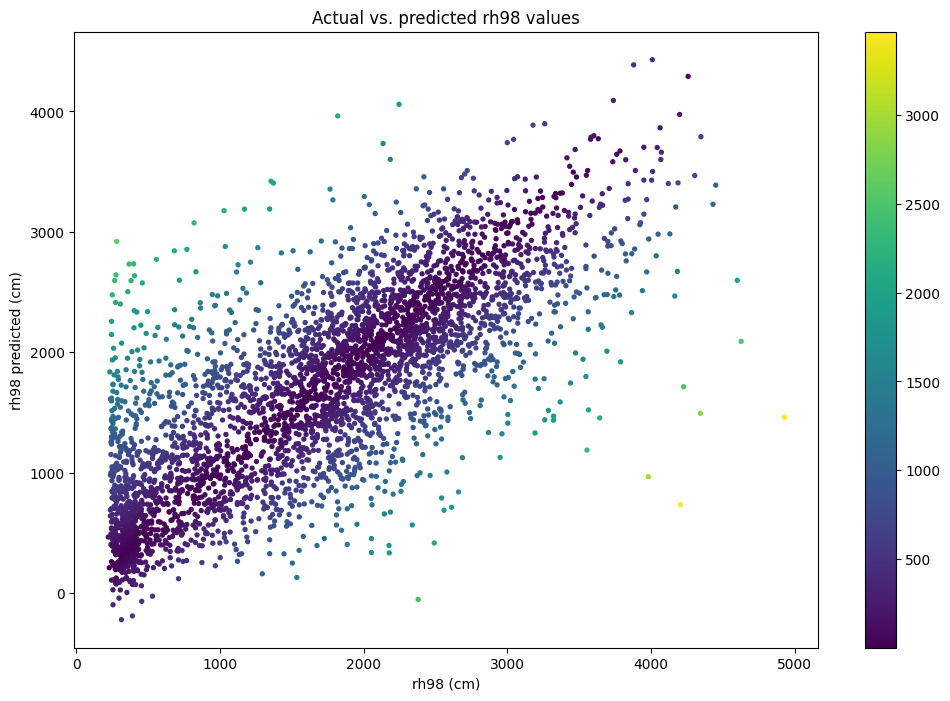

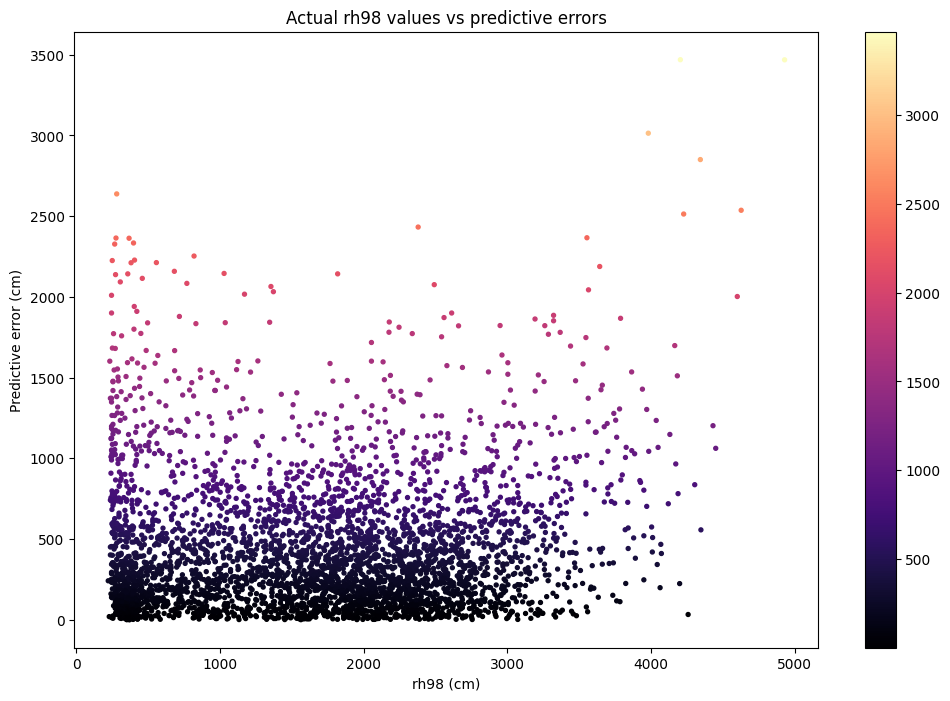

In [17]:
utils.plot_scatter(X_test, var_x="rh98", var_y="rh98_pred", color_var="rh98_error", title="Actual vs. predicted rh98 values", x_label="rh98 (cm)", y_label="rh98 predicted (cm)")
utils.plot_scatter(X_test, var_x="rh98", var_y="rh98_error", color_var="rh98_error", title="Actual rh98 values vs predictive errors", x_label="rh98 (cm)", y_label="Predictive error (cm)", cmap="magma")

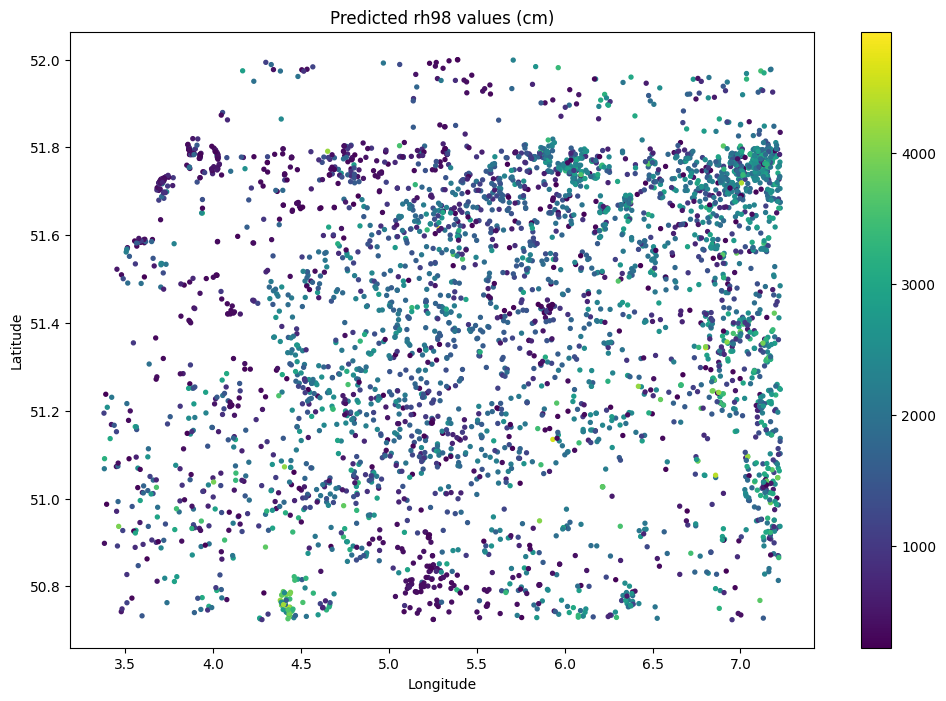

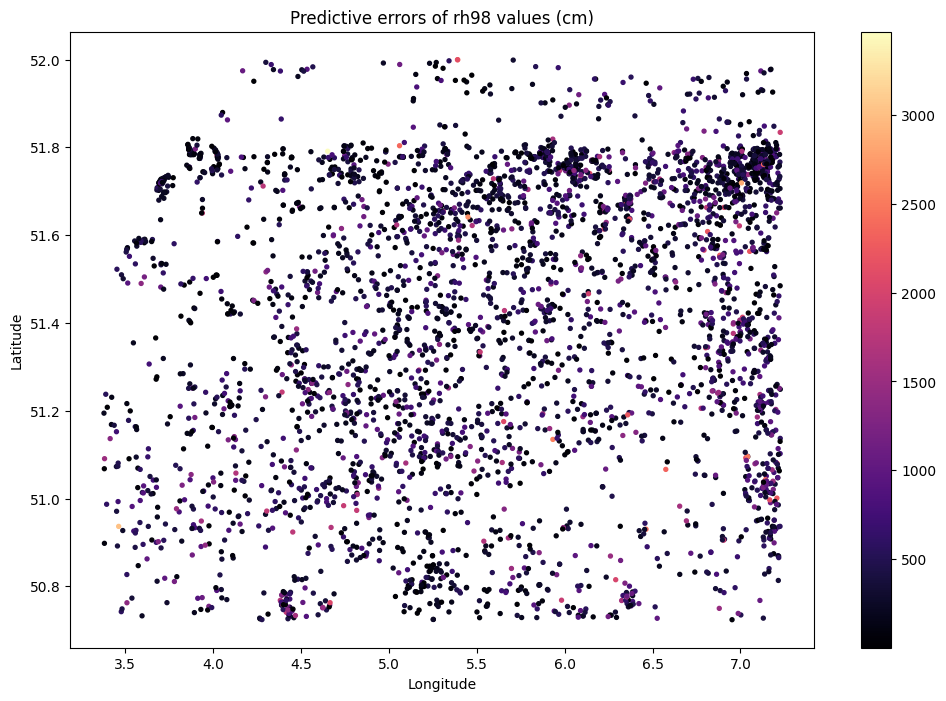

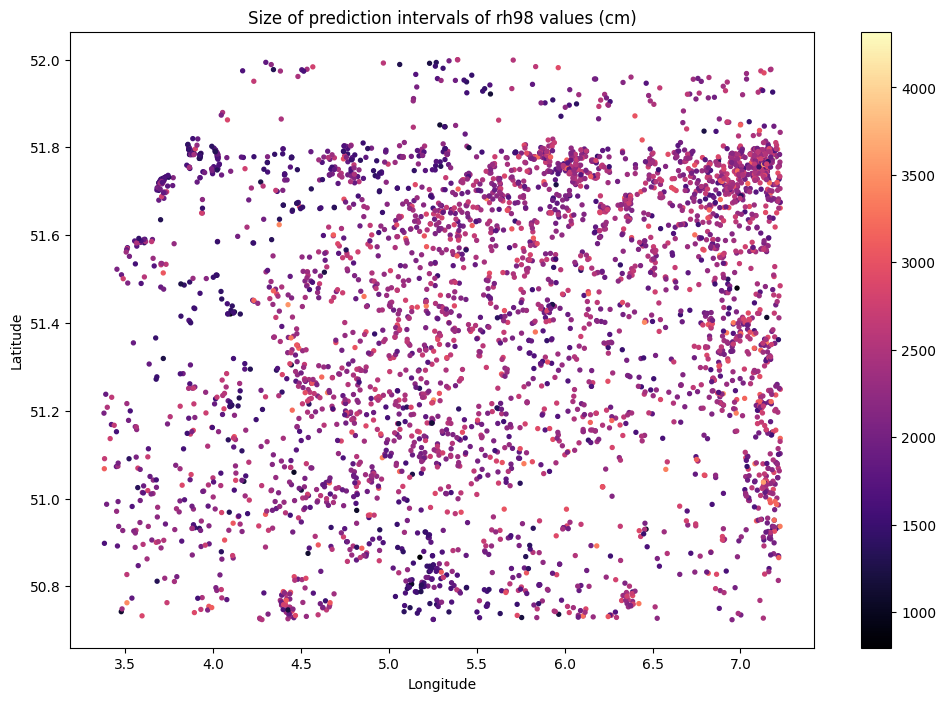

In [18]:
utils.plot_scatter(df=X_test, var_x="lon", var_y="lat", color_var="rh98", title="Predicted rh98 values (cm)", x_label="Longitude", y_label="Latitude")
utils.plot_scatter(df=X_test, var_x="lon", var_y="lat", color_var="rh98_error", title="Predictive errors of rh98 values (cm)", x_label="Longitude", y_label="Latitude", cmap="magma")
utils.plot_scatter(df=X_test, var_x="lon", var_y="lat", color_var="rh98_pred_size", title="Size of prediction intervals of rh98 values (cm)", x_label="Longitude", y_label="Latitude", cmap="magma")

#### Apply model to test dataset
The fitted LGBM estimator is applied to the proper test dataset of the hackathon. The column ordering is changed to the that of the training data. The results are exported as a .csv file.

In [ ]:
testing_data = pd.read_csv("./data/test.csv")
ids = testing_data["id"]
testing_data = testing_data.reindex(X_train.columns, axis=1)
res = testing_data
res["rh98"] = lgb.predict(res)
res["id"] = ids
res[["id", "rh98"]].to_csv("./results_alexander_pilz.csv", index=False)

## Literature

[1] C. Bonannella, Y.-F. Ho. Canopy height mapping using Google 'AEF embeddings'. [https://kaggle.com/competitions/canopy-height-mapping-using-google-aef-embeddings](https://kaggle.com/competitions/canopy-height-mapping-using-google-aef-embeddings), 2025. Kaggle.

[2] J. Lei, M. G’Sell, A. Rinaldo, R. J. Tibshirani, and L. Wasserman, ‘Distribution-Free Predictive Inference For Regression’, Journal of the American Statistical Association, vol. 113, Aug. 2018, doi: 10.1080/01621459.2017.1307116.

[3] H. Linusson, U. Johansson, and T. Löfström, ‘Signed-Error Conformal Regression’, in Proceedings of the 18th Pacific-Asia Conference, Tainan, Taiwan, May 2014. doi: 10.1007/978-3-319-06608-0.

[4] Y. Romano, E. Patterson, and E. J. Candès, ‘Conformalized quantile regression’, in Proceedings of the 33rd International Conference on Neural Information Processing Systems, Vancouver, Canada Aug. 2019. doi: 10.48550/arXiv.1905.03222.
